In [1]:
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt
import pandas as pd
from osc_toolkit import oscillation, delayed_oscillation
from models import *
from functools import partial
from ddeint import ddeint

In [2]:
files = ['Data_sets/1_expB_osc_NatChem_MH.csv',
         'Data_sets/3b_expB_osc_NatChem_MH.csv',
         'Data_sets/4_expB_osc_NatChem_MH.csv']

df_list = [pd.read_csv(file) for file in files]

exp_data = pd.concat(df_list, axis=1)

exp_data.columns = ['t1', 'c1', 't3b', 'c3b', 't4', 'c4']

cut_off, CMC_3b = 112, 0.52
tau = 0.25
C_A2tol = exp_data.loc[0, 'c1'] + exp_data.loc[0, 'c4'] / 2

exp_data = exp_data.head(cut_off)
exp_data[['c1', 'c4']] /= C_A2tol
exp_data['c3b'] /= CMC_3b

for s in ['t1', 't3b', 't4']:
    exp_data = exp_data.drop_duplicates(subset=s)
    exp_data[s] /= tau

print(C_A2tol)


df_MHNatChem = exp_data.clip(lower=0)
df_MHNatChem.loc[0, 't3b'] = 0
df_MHNatChem.loc[0, 't4'] = 0

3.1426606946408935


In [12]:
params = np.array([2.7, 1.14, 0.54, 9])
consts = [0.17, 2]
init_cond = [0.1, 0]

model = oscillation(approx_model_FTC, params, consts, init_cond, calc_all_approx_model_FTC)
model.add_exp_data(df_MHNatChem)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).


In [13]:
model.interactive_plot(exp=True, ran=10, step=0.01)

interactive(children=(FloatSlider(value=2.7, description='alpha', max=12.7, step=0.01), FloatSlider(value=1.14…

alpha = 105.814, beta = 0.650, theta = 21.282, phi = 11.833


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 38.677406140628314
             x: [ 1.058e+02  6.503e-01  2.128e+01  1.183e+01]
           nit: 247
          nfev: 556
 final_simplex: (array([[ 1.058e+02,  6.503e-01,  2.128e+01,  1.183e+01],
                       [ 1.058e+02,  6.503e-01,  2.128e+01,  1.183e+01],
                       ...,
                       [ 1.058e+02,  6.503e-01,  2.128e+01,  1.183e+01],
                       [ 1.058e+02,  6.503e-01,  2.128e+01,  1.183e+01]]), array([ 3.868e+01,  3.868e+01,  3.868e+01,  3.868e+01,
                        3.868e+01]))

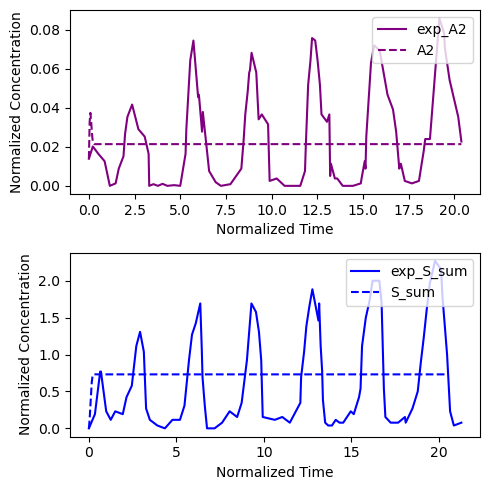

In [14]:
model.fit(plot=True, overwrite=True)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).


(<Figure size 500x500 with 2 Axes>,
 array([<Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>,
        <Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>],
       dtype=object))

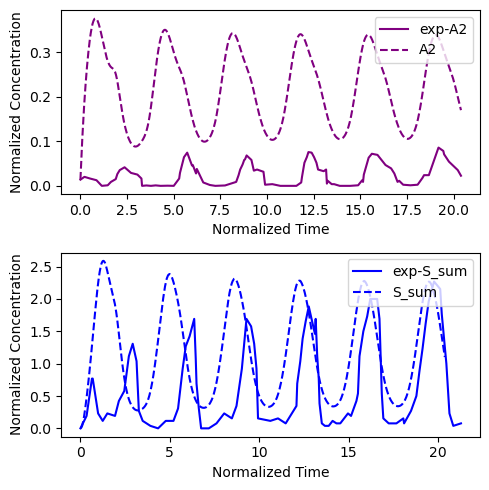

In [5]:
params = np.array([1.4, 0.62, 2, 5.1, 8])
consts = [0.17, 2]
init_cond = [0.1, 0]
delayed_model = delayed_oscillation(delayed_approx_model_FTC, delay=1, params=params, consts=consts, init_cond=init_cond, calc_all=calc_all_delayed_approx_model_FTC)
delayed_model.set_delay((0.2, 1.45))
delayed_model.add_exp_data(df_MHNatChem)
delayed_model.plot(t=5, exp=True)

In [6]:
delayed_model.interactive_plot(exp=True, ran=5, step=0.02)

interactive(children=(FloatSlider(value=1.4, description='alpha', max=6.4, step=0.02), FloatSlider(value=0.62,…

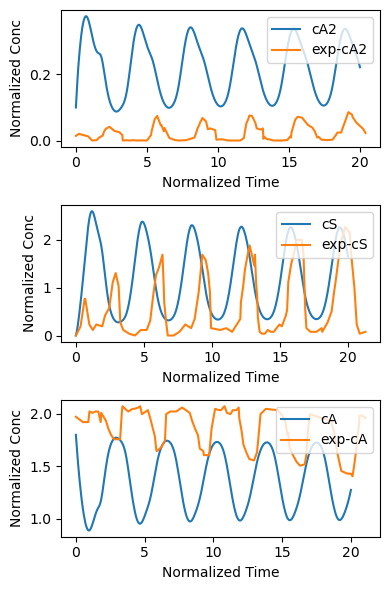

In [7]:
sol, t = delayed_model.simulate(t=20)
cA2 = sol[:, 0]
cS = sol[:, 1]
cA = 2 * (1 - cA2) - consts[0] * (cS + cS**consts[1])
fig, ax = plt.subplots(3, 1, figsize=(4, 6))

ax[0].plot(t, cA2, label='cA2')
ax[0].plot(df_MHNatChem['t1'], df_MHNatChem['c1'], label='exp-cA2')
ax[0].set_xlabel('Normalized Time')
ax[0].set_ylabel('Normalized Conc')
ax[0].legend(loc='upper right')

ax[1].plot(t, cS + cS**consts[1], label='cS')
ax[1].plot(df_MHNatChem['t3b'], df_MHNatChem['c3b'], label='exp-cS')
ax[1].set_xlabel('Normalized Time')
ax[1].set_ylabel('Normalized Conc')
ax[1].legend(loc='upper right')

ax[2].plot(t, cA, label='cA')
ax[2].plot(df_MHNatChem['t4'], df_MHNatChem['c4'], label='exp-cA')
ax[2].set_xlabel('Normalized Time')
ax[2].set_ylabel('Normalized Conc')
ax[2].legend(loc='upper right')

plt.tight_layout()

In [8]:
cA2_tol = 14.5
CMC_3a = 1.56
tau = 1.15
df_3a_fig3_NatChem = pd.read_csv('Data_sets/3a_fig3_osc_NatChem_MH.csv')
df_3a_fig3_NatChem['Time'] /= tau
df_3a_fig3_NatChem['S3a'] /= CMC_3a
df_3a_fig3_NatChem.plot(x='Time', y='S3a')

KeyError: 'Time'

In [ ]:
params = np.array([13, 7, 2, 16, 20])
params_nd = np.array([13, 7, 2, 16])
consts = [0.11, 3]
delay = np.array([0.05, 0.1])
init_cond = [0.1, 0]
model_fig3 = oscillation(approx_model_FTC, params_nd, consts, init_cond, calc_all_approx_model_FTC)
delayed_model_fig3 = delayed_oscillation(delayed_approx_model_FTC, delay=delay, params=params, consts=consts, init_cond=init_cond, calc_all=calc_all_delayed_approx_model_FTC)

In [ ]:
delayed_model_fig3.add_exp_data(df_3a_fig3_NatChem)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).


In [ ]:
model_fig3.add_exp_data(df_3a_fig3_NatChem)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).


In [ ]:
delayed_model_fig3.interactive_plot(ran=50, t=5, exp=True)

interactive(children=(FloatSlider(value=13.0, description='alpha', max=63.0, step=0.05), FloatSlider(value=7.0…

(<Figure size 500x500 with 2 Axes>,
 array([<Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>,
        <Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>],
       dtype=object))

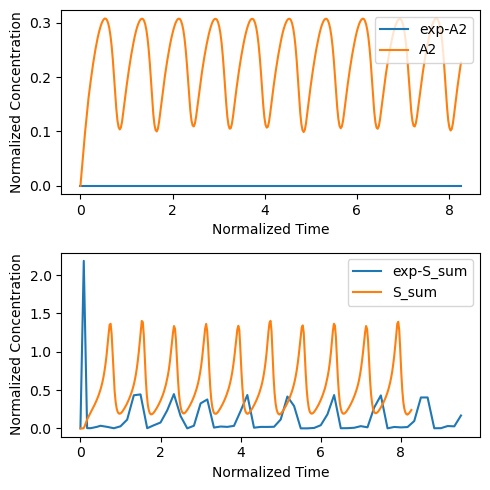

In [ ]:
delayed_model_fig3.set_delay([0.02, 0.08])
delayed_model_fig3.plot(t=3, exp=True)